In [15]:
import awswrangler as wr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys

In [16]:
repo_name = "mercury-pipeline-metaapi-sam"
sys.path.append(os.getcwd().split(repo_name)[0] + repo_name + "/lambda") 

In [17]:
import app

In [18]:
pd.set_option('display.max_columns', None)

In [31]:
path = "s3://datalake.dgriffiths.io/projects/mercury/data/clean/candles/transformed/symbol=GBPUSD/frequency=1T/year=2022/month=07/date=20220704/"

In [32]:
df = wr.s3.read_parquet(path, dataset=True)

In [33]:
df.head(3)

,timestamp_utc.open,ask.open,ask.close,ask.low,ask.high,n_ticks,bid.open,bid.close,bid.low,bid.high,ask.idx_hi_lo,bid.idx_hi_lo,timestamp_utc.close,timestamp_uk.open,timestamp_uk.close,ema_1,ema_10,ema_21,ema_50,ema_up,ema_dn,ema_up_start,ema_dn_start,ema_up_stop,ema_dn_stop,ema_up_i,ema_dn_i,ema_up_idx,ema_up_entry,ema_up_exit,ema_up_profit,ema_dn_idx,ema_dn_entry,ema_dn_exit,ema_dn_profit,symbol,frequency,year,month,date,hour
0,2022-07-04 00:00:00,1.21007,1.21062,1.20994,1.21072,153,1.20977,1.21049,1.20977,1.21059,lo,lo,2022-07-04 00:01:00,2022-07-04 01:00:00,2022-07-04 01:01:00,1.21062,1.210468,1.210562,1.210752,False,True,False,False,False,False,<NA>,KDQYNYFPCGAWFSXWFDCE,NaN,<NA>,<NA>,NaN,30.0,False,True,-0.00017,GBPUSD,1T,2022,07,20220704,00
1,2022-07-04 00:01:00,1.21063,1.21072,1.21063,1.21101,136,1.21049,1.21058,1.21049,1.21088,lo,lo,2022-07-04 00:02:00,2022-07-04 01:01:00,2022-07-04 01:02:00,1.21072,1.210514,1.210577,1.210751,False,True,False,False,False,False,<NA>,KDQYNYFPCGAWFSXWFDCE,NaN,<NA>,<NA>,NaN,31.0,False,False,NaN,GBPUSD,1T,2022,07,20220704,00
2,2022-07-04 00:02:00,1.21071,1.21036,1.21034,1.21084,141,1.21058,1.21023,1.21022,1.21072,hi,hi,2022-07-04 00:03:00,2022-07-04 01:02:00,2022-07-04 01:03:00,1.21036,1.210486,1.210557,1.210736,False,True,False,False,False,False,<NA>,KDQYNYFPCGAWFSXWFDCE,NaN,<NA>,<NA>,NaN,32.0,False,False,NaN,GBPUSD,1T,2022,07,20220704,00


In [34]:
%%time
l = []
for key in wr.s3.list_objects(
    "s3://datalake.dgriffiths.io/projects/mercury/data/clean/candles/transformed/symbol=GBPUSD/frequency=1T/"
):
    dfi = wr.s3.read_parquet(key)
    if "ema_up_entry" in dfi.columns:
        l.append(dfi[dfi["ema_up_entry"] == True])

CPU times: total: 20.7 s
Wall time: 1min 15s


In [35]:
%%time
df = pd.concat(l)

CPU times: total: 219 ms
Wall time: 220 ms


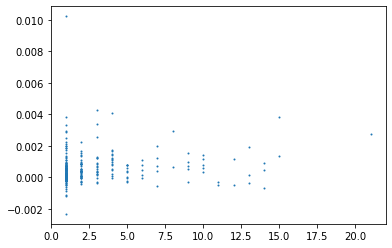

In [36]:
plt.scatter(
    df["ema_up_idx"],
    df["ema_up_profit"],
    s=1
)

In [37]:
import seaborn as sns

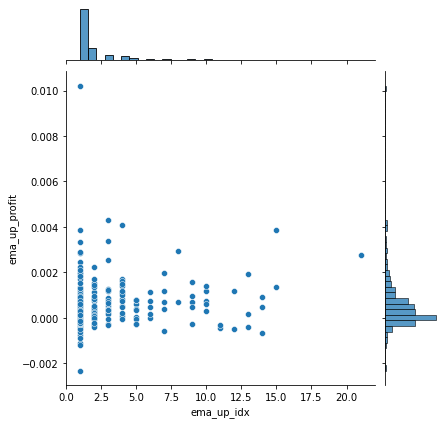

In [61]:
sns.jointplot(data=df.reset_index(drop=True), x="ema_up_idx", y="ema_up_profit")

In [67]:
df["time_window"] = (df["timestamp_utc.open"].dt.floor("10T") - df["timestamp_utc.open"].dt.floor("1D")).dt.total_seconds() / 3600

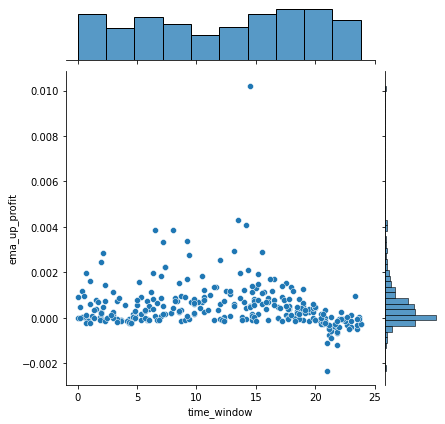

In [81]:
g = sns.jointplot(
    data=df.reset_index(drop=True),
    x="time_window",
    y="ema_up_profit",
    xlim=(-1, 25),
)

<AxesSubplot:xlabel='time_window', ylabel='ema_up_idx'>

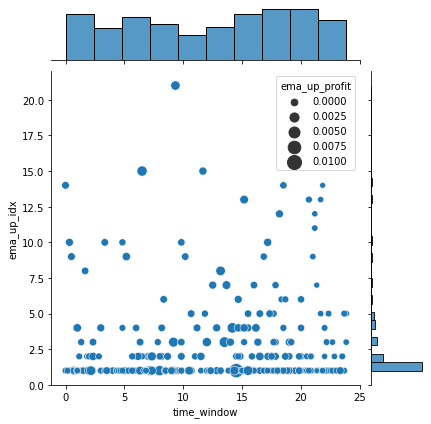

In [83]:
g = sns.jointplot(
    data=df.reset_index(drop=True),
    x="time_window",
    y="ema_up_idx",
    xlim=(-1, 25),
    # ylim=(0, 0.01),
)
g.ax_joint.cla()
sns.scatterplot(
    data=df.reset_index(drop=True),
    x='time_window',
    y='ema_up_idx',
    size='ema_up_profit',
    sizes=(10, 200),
    ax=g.ax_joint
)